In [1]:
"""
-*-coding = utf-8 -*-
__author: topsy
@time:2021/12/13 21:55
"""

import torch
import logging
 
logger = logging.getLogger(__name__)

from utils.cifar2_data_loader import get_cifar2_dataset, get_cifar2_dataloader
from torch.nn import CrossEntropyLoss

trainset, testset = get_cifar2_dataset()
dataset_sizes = {"train": len(trainset), "test": len(testset)}
train_loader, test_loader = get_cifar2_dataloader()

***** Current use the cifar2 dataset for train and test.  *****
***** Current use the cifar2 dataset for train and test.  *****


In [2]:
def valid(model, test_loader ):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Validation!
    logger.info("***** Running Validation *****")
    logger.info("  Num steps = %d", len(test_loader))
    logger.info("  Batch size = %d", test_loader.batch_size)
    model.eval()
    model.to(device)
    correct_count = 0
    num_samples = dataset_sizes["test"]
    loss = 0.0
    loss_fct = CrossEntropyLoss()
    error_cases = None
    error_cases_gt = []
    
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits, _ = model(x)
            _, preds = torch.max(logits, dim=-1)
            batch_loss = loss_fct(logits.view(-1, 2), y.view(-1))
            loss += batch_loss.item() * x.size(0)
            correct_count += torch.sum(preds == y.data)
            batch_error_caese = x[preds != y.data]
            if len(batch_error_caese) > 0:
                if error_cases != None:
                    error_cases = torch.vstack([error_cases, batch_error_caese])
                else:
                    error_cases = batch_error_caese
                error_cases_gt += list(y.data[preds != y.data])
                

    avg_loss = loss * 1.0 / dataset_sizes["test"]
    avg_acc = correct_count * 1.0 / dataset_sizes["test"]
    print('Test Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))
    return avg_loss, avg_acc, error_cases, error_cases_gt






In [3]:
from models.modeling import VisionTransformer, CONFIGS

def get_model(pretrained_dir, num_classes=2, model_type="ViT-B_16", img_size=224, ):
    config = CONFIGS[model_type]
    model = VisionTransformer(config, img_size, zero_head=True, num_classes=num_classes)
    model.load_state_dict(torch.load(pretrained_dir))
    return model


In [4]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
def imshow(img, title):
    img = img/2 +0.5
    npimg = img.detach().cpu().numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

# ViT-B_16 ALL layers

In [5]:
pretrained_dir = "./output/cifar2_all_layers_1213_2_checkpoint.bin"
model = get_model(pretrained_dir)

In [6]:
avg_loss, avg_acc, error_cases, error_cases_gt = valid(model, test_loader)

Test Loss: 0.1519 Acc: 0.9804


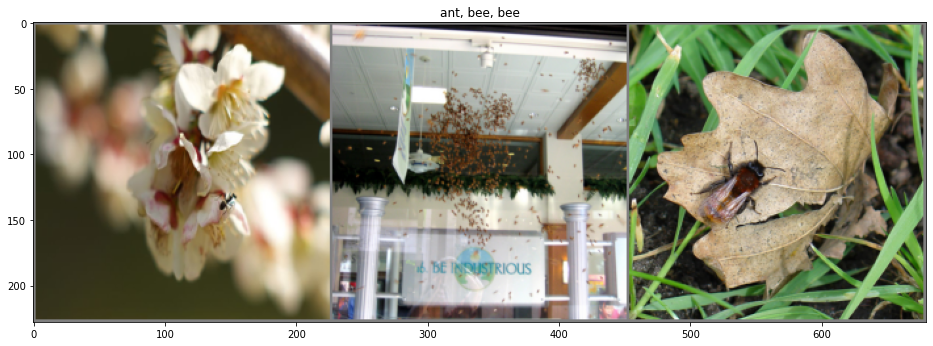

In [8]:
class_name = {0: "ants", 1: "bees"}
gt_labels  = [class_name[id.detach().cpu().item()][:-1] for id in error_cases_gt]
title = ", ".join(gt_labels)
imshow(torchvision.utils.make_grid(error_cases, 4), title)

# ViT-L_16 ALL layers

In [10]:
pretrained_dir = "./output/cifar2_VIT_L16_all_layers_1213_01_checkpoint.bin"
model = get_model(pretrained_dir, model_type="ViT-L_16")

In [11]:
avg_loss, avg_acc, error_cases, error_cases_gt = valid(model, test_loader)

Test Loss: 0.0992 Acc: 0.9869


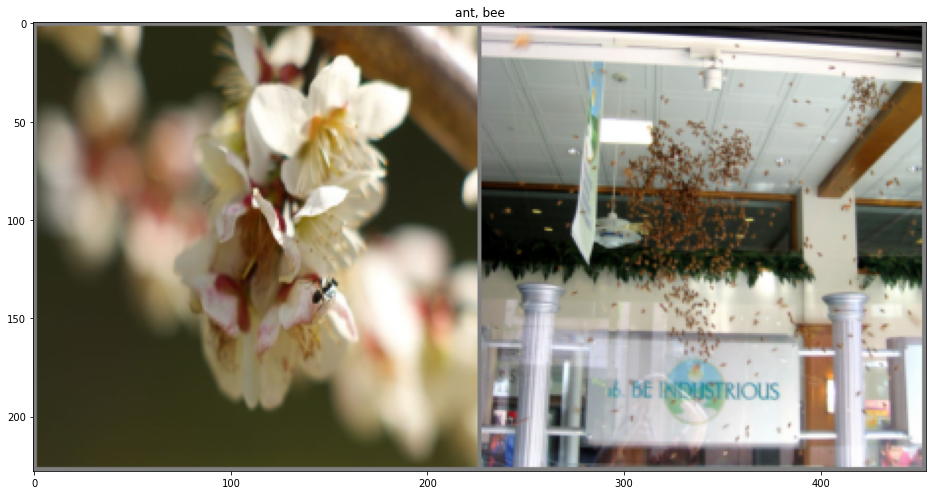

In [12]:
gt_labels  = [class_name[id.detach().cpu().item()][:-1] for id in error_cases_gt]
title = ", ".join(gt_labels)
imshow(torchvision.utils.make_grid(error_cases, 4), title)